<a href="https://colab.research.google.com/github/shreyasrajesh0308/NNDL-proj/blob/main/Copy_of_preprocessing_filters.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Model Paper: 

### Load Data 

Load preprocessed data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
from matplotlib import pyplot as plt
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier

In [ ]:

X_test = np.load("/content/drive/MyDrive/eeg_project/X_test.npy")
y_test = np.load("/content/drive/MyDrive/eeg_project/y_test.npy")
person_train_valid = np.load("/content/drive/MyDrive/eeg_project/person_train_valid.npy")
X_train_valid = np.load("/content/drive/MyDrive/eeg_project/X_train_valid.npy")
y_train_valid = np.load("/content/drive/MyDrive/eeg_project/y_train_valid.npy")
person_test = np.load("/content/drive/MyDrive/eeg_project/person_test.npy")


In [ ]:
print ('Training/Valid data shape: {}'.format(X_train_valid.shape))
print ('Test data shape: {}'.format(X_test.shape))
print ('Training/Valid target shape: {}'.format(y_train_valid.shape))
print ('Test target shape: {}'.format(y_test.shape))
print ('Person train/valid shape: {}'.format(person_train_valid.shape))
print ('Person test shape: {}'.format(person_test.shape))


Training/Valid data shape: (2115, 22, 1000)
Test data shape: (443, 22, 1000)
Training/Valid target shape: (2115,)
Test target shape: (443,)
Person train/valid shape: (2115, 1)
Person test shape: (443, 1)


In [ ]:
print(np.unique(y_train_valid))
print(np.unique(y_test))

[769 770 771 772]
[769 770 771 772]


In [ ]:
num_classes = 4
y_train_valid = y_train_valid-769
y_test = y_test-769

In [ ]:
def data_prep(X,y,sub_sample,average,noise):
    
    total_X = None
    total_y = None
    
    # Trimming the data (sample,22,1000) -> (sample,22,500)
    X = X[:,:,0:500]
    print('Shape of X after trimming:',X.shape)
    
    # Maxpooling the data (sample,22,1000) -> (sample,22,500/sub_sample)
    X_max = np.max(X.reshape(X.shape[0], X.shape[1], -1, sub_sample), axis=3)
    
    
    total_X = X_max
    total_y = y
    print('Shape of X after maxpooling:',total_X.shape)
    
    # Averaging + noise 
    X_average = np.mean(X.reshape(X.shape[0], X.shape[1], -1, average),axis=3)
    X_average = X_average + np.random.normal(0.0, 0.5, X_average.shape)
    
    total_X = np.vstack((total_X, X_average))
    total_y = np.hstack((total_y, y))
    print('Shape of X after averaging+noise and concatenating:',total_X.shape)
    
    # Subsampling
    
    for i in range(sub_sample):
        
        X_subsample = X[:, :, i::sub_sample] + \
                            (np.random.normal(0.0, 0.5, X[:, :,i::sub_sample].shape) if noise else 0.0)
            
        total_X = np.vstack((total_X, X_subsample))
        total_y = np.hstack((total_y, y))
        
    
    print('Shape of X after subsampling and concatenating:',total_X.shape)
    return total_X,total_y


X_train_valid_prep,y_train_valid_prep = data_prep(X_train_valid,y_train_valid,2,2,True)


Shape of X after trimming: (2115, 22, 500)
Shape of X after maxpooling: (2115, 22, 250)
Shape of X after averaging+noise and concatenating: (4230, 22, 250)
Shape of X after subsampling and concatenating: (8460, 22, 250)


In [ ]:
def data_prep_test(X,y, sub_sample=2):
    
    total_X = None
    total_y = None
    
    # Trimming the data (sample,22,1000) -> (sample,22,500)
    X = X[:,:,0:500]
    print('Shape of X after trimming:',X.shape)
    
    # Maxpooling the data (sample,22,1000) -> (sample,22,500/sub_sample)
    X_max = np.max(X.reshape(X.shape[0], X.shape[1], -1, sub_sample), axis=3)
    
    
    total_X = X_max
    total_y = y
    print('Shape of X after maxpooling:',total_X.shape)
    return total_X,total_y


X_test,y_test = data_prep_test(X_test, y_test,2)


Shape of X after trimming: (443, 22, 500)
Shape of X after maxpooling: (443, 22, 250)


In [ ]:
def spatial_prep(X):
  # new_X = []
  # X = X.tolist()
  X = np.swapaxes(X, 0, 1)

  sh = (X.shape[1],X.shape[2])
  new_X = np.array([[np.zeros(sh), np.zeros(sh), np.zeros(sh), X[0,:,:], np.zeros(sh), np.zeros(sh), np.zeros(sh)],
                [np.zeros(sh), X[1,:,:], X[2,:,:], X[3,:,:], X[4,:,:], X[5,:,:], np.zeros(sh)],
                [X[6,:,:],X[7,:,:],X[8,:,:],X[9,:,:],X[10,:,:],X[11,:,:],X[12,:,:]],
                [np.zeros(sh), X[13,:,:],X[14,:,:],X[15,:,:],X[16,:,:],X[17,:,:], np.zeros(sh)],
                [np.zeros(sh), np.zeros(sh), X[18,:,:],X[19,:,:],X[20,:,:], np.zeros(sh), np.zeros(sh)],
                [np.zeros(sh), np.zeros(sh), np.zeros(sh), X[21,:,:], np.zeros(sh), np.zeros(sh), np.zeros(sh)]])

  # for x_seq in X:
  #   n = len(X)
  #   # new_seq_X = np.array([np.array([np.zeros(n), np.zeros(n), np.zeros(n), np.array(x_seq[0]), np.zeros(n), np.zeros(n), np.zeros(n)]),
  #   #              np.array([np.zeros(n), np.array(x_seq[1]), np.array(x_seq[2]), np.array(x_seq[3]), np.array(x_seq[4]), np.array(x_seq[5]), np.zeros(n)]),
  #   #              np.array([np.array(x_seq[6]), np.array(x_seq[7]), np.array(x_seq[8]), np.array(x_seq[9]), np.array(x_seq[10]), np.array(x_seq[11]), np.array(x_seq[12])]),
  #   #              np.array([np.zeros(n), np.array(x_seq[13]), np.array(x_seq[14]), np.array(x_seq[15]), np.array(x_seq[16]), np.array(x_seq[17]), np.zeros(n)]),
  #   #              np.array([np.zeros(n), np.zeros(n), np.array(x_seq[18]), np.array(x_seq[19]), np.array(x_seq[20]), np.zeros(n), np.zeros(n)]),
  #   #              np.array([np.zeros(n), np.zeros(n), np.zeros(n), np.array(x_seq[21]), np.zeros(n), np.zeros(n), np.zeros(n)])])
  #   # new_X.append(new_seq_X)
  #   new_seq_X = np.array([[[0]*n, [0]*n, [0]*n, x_seq[0], [0]*n, [0]*n, [0]*n ],
  #                [[0]*n, x_seq[1], x_seq[2], x_seq[3], x_seq[4], x_seq[5], [0]*n ],
  #                [x_seq[6], x_seq[7], x_seq[8], x_seq[9], x_seq[10], x_seq[11], x_seq[12]],
  #                [[0]*n, x_seq[13], x_seq[14], x_seq[15], x_seq[16], x_seq[17], [0]*n],
  #                [[0]*n, [0]*n, x_seq[18], x_seq[19], x_seq[20], [0]*n, [0]*n],
  #                [[0]*n, [0]*n, [0]*n, x_seq[21], [0]*n, [0]*n, [0]*n]])
  #   new_X.append(new_seq_X)

  # new_X = np.array(new_X)
  new_X = np.swapaxes(new_X, 0,2)
  new_X = np.swapaxes(new_X, 1,2)
  return new_X

In [ ]:
X_spatial_prep = spatial_prep(X_train_valid_prep)

In [ ]:
X_spatial_test = spatial_prep(X_test)

In [ ]:
print(X_spatial_prep.shape, X_spatial_test.shape)

(8460, 6, 7, 250) (443, 6, 7, 250)


In [ ]:
X_train_copy = X_train_valid_prep.copy()
X_test_copy = X_test.copy()

from scipy import signal

n, wn = signal.buttord(wp=[8, 13], ws=[6, 18], fs=125, gpass=1, gstop=36)
sos1 = signal.butter(n, wn, btype='bandpass', fs=125, output='sos')

n, wn = signal.buttord(wp=[13, 30], ws=[8, 48], fs=125, gpass=1, gstop=36)
sos2 = signal.butter(n, wn, btype='bandpass', fs=125, output='sos')

X_train_valid_filtered_1 = signal.sosfiltfilt(sos1, X_train_valid_prep, axis=-1)
X_train_valid_prep = signal.sosfiltfilt(sos2, X_train_valid_filtered_1, axis=-1)
X_test_filtered_1 = signal.sosfiltfilt(sos1, X_test, axis=-1)
X_test = signal.sosfiltfilt(sos2, X_test_filtered_1, axis=-1)

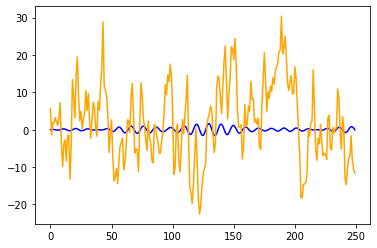

In [ ]:
plt.plot(X_train_valid_prep[0][0], color = 'blue')
plt.plot(X_train_copy[0][0], color = 'orange')

In [ ]:

y_train_valid_prep = keras.utils.to_categorical(y_train_valid_prep, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

In [ ]:
print(X_train_valid_prep.shape,y_train_valid_prep.shape, X_spatial_prep.shape, X_spatial_test.shape)
print(X_test.shape, y_test.shape)

(8460, 22, 250) (8460, 4) (8460, 6, 7, 250) (443, 6, 7, 250)
(443, 22, 250) (443, 4)


In [ ]:
X_spatial_prep  = np.swapaxes(X_spatial_prep , 1,3)
X_spatial_prep = np.swapaxes(X_spatial_prep , 2,3)
X_spatial_test  = np.swapaxes(X_spatial_test , 1,3)
X_spatial_test = np.swapaxes(X_spatial_test , 2,3)

In [ ]:
X_spatial_prep = X_spatial_prep.reshape(*X_spatial_prep.shape, 1)
X_spatial_test = X_spatial_test.reshape(*X_spatial_test.shape, 1)

In [ ]:
print(X_train_valid_prep.shape,y_train_valid_prep.shape, X_spatial_prep.shape, X_spatial_test.shape)
print(X_test.shape, y_test.shape)

(8460, 22, 250) (8460, 4) (8460, 250, 6, 7, 1) (443, 250, 6, 7, 1)
(443, 22, 250) (443, 4)


## CNN + GRU model with all subjects

In [ ]:
from keras.layers import Conv2D, BatchNormalization, Activation, Flatten, Dense, Dropout, LSTM, Input, TimeDistributed, Permute, Reshape, MaxPooling2D, GRU
from keras import initializers, Model, optimizers, callbacks
from keras import Sequential
from keras import backend as K
from keras.models import load_model
from keras.callbacks import Callback
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score

In [ ]:
## Complicated Model - the same as Zhang`s
# input_shape = (250, 6, 7, 1)
# lecun = initializers.lecun_normal(seed=42)

# # TimeDistributed Wrapper
# def timeDist(layer, prev_layer, name):
#     return TimeDistributed(layer, name=name)(prev_layer)
    
# # Input layer
# inputs = Input(shape=input_shape)

# # Convolutional layers block
# x = timeDist(Conv2D(32, (3,3), padding='same', 
#                     data_format='channels_last', kernel_initializer=lecun), inputs, name='CNN1')
# x = BatchNormalization(name='batch1')(x)
# x = Activation('elu', name='act1')(x)
# x = timeDist(Conv2D(64, (3,3), padding='same', data_format='channels_last', kernel_initializer=lecun), x, name='CNN2')
# x = BatchNormalization(name='batch2')(x)
# x = Activation('elu', name='act2')(x)
# x = timeDist(Conv2D(128, (3,3), padding='same', data_format='channels_last', kernel_initializer=lecun), x, name='CNN3')
# x = BatchNormalization(name='batch3')(x)
# x = Activation('elu', name='act3')(x)
# x = timeDist(Flatten(), x, name='flatten')

# # Fully connected layer block
# y = Dense(64, kernel_initializer=lecun, name='FC')(x)
# y = Dropout(0.5, name='dropout1')(y)
# y = BatchNormalization(name='batch4')(y)
# y = Activation(activation='elu')(y)

# # Recurrent layers block
# #z = LSTM(64, kernel_initializer=lecun, return_sequences=True, name='LSTM1')(y)
# z = LSTM(64, kernel_initializer=lecun, name='LSTM2')(y)

# # Fully connected layer block
# h = Dense(128, kernel_initializer=lecun, activation='relu', name='FC2')(z)
# h = Dropout(0.5, name='dropout2')(h)

# # Output layer
# outputs = Dense(4, activation='softmax')(h)

# # Model compile
# model = Model(inputs=inputs, outputs=outputs)
# model.summary()

lecun = initializers.lecun_normal(seed=42)

model = Sequential()

model.add(Permute((2, 1), input_shape=(22, 250)))
model.add(Reshape((250, 22, 1)))

model.add(Conv2D(filters=25, kernel_size=(10,1), kernel_initializer = lecun, strides=1, data_format="channels_last"))
model.add(Conv2D(filters=25, kernel_size=(1,22), kernel_initializer = lecun ))
model.add(BatchNormalization())
model.add(Activation(activation = 'elu'))
model.add(MaxPooling2D(pool_size = (3,1), strides = (3,1)))
model.add(Dropout(0.5))

# Conv Pool Block 2
model.add(Conv2D(filters = 50, kernel_size = (10,1), activation = 'elu', kernel_initializer = lecun))
model.add(BatchNormalization())
model.add(Activation(activation = 'elu'))
model.add(MaxPooling2D(pool_size = (3,1), strides = (3,1)))
model.add(Dropout(0.5))

model.add(Permute((1, 3, 2)))
model.add(Reshape((23, 50)))

# GRU layers
model.add(GRU(16, return_sequences=True))
model.add(GRU(16, return_sequences=True))
# model.add(GRU(16, return_sequences=True))
# model.add(GRU(16, return_sequences=True))
model.add(Dropout(0.5))

# Dense layers
model.add(Flatten())
model.add(Dense(units=4, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

print(model.summary())


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 permute (Permute)           (None, 250, 22)           0         
                                                                 
 reshape (Reshape)           (None, 250, 22, 1)        0         
                                                                 
 conv2d (Conv2D)             (None, 241, 22, 25)       275       
                                                                 
 conv2d_1 (Conv2D)           (None, 241, 1, 25)        13775     
                                                                 
 batch_normalization (BatchN  (None, 241, 1, 25)       100       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 241, 1, 25)        0         
                                                        

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
history = model.fit(X_train_valid_prep, y_train_valid_prep, batch_size=64, epochs=1000, shuffle=True,
                    validation_split=0.2)

Epoch 1/1000
106/106 [==============================] - 18s 37ms/step - loss: 1.4364 - acc: 0.2575 - val_loss: 1.3936 - val_acc: 0.2689
Epoch 2/1000
106/106 [==============================] - 2s 22ms/step - loss: 1.3914 - acc: 0.2806 - val_loss: 1.3610 - val_acc: 0.2996
Epoch 3/1000
106/106 [==============================] - 2s 23ms/step - loss: 1.3723 - acc: 0.3019 - val_loss: 1.3416 - val_acc: 0.3375
Epoch 4/1000
106/106 [==============================] - 3s 24ms/step - loss: 1.3487 - acc: 0.3329 - val_loss: 1.3152 - val_acc: 0.3576
Epoch 5/1000
106/106 [==============================] - 3s 29ms/step - loss: 1.3247 - acc: 0.3508 - val_loss: 1.2950 - val_acc: 0.3552
Epoch 6/1000
106/106 [==============================] - 3s 26ms/step - loss: 1.3018 - acc: 0.3766 - val_loss: 1.2533 - val_acc: 0.4072
Epoch 7/1000
106/106 [==============================] - 3s 26ms/step - loss: 1.2760 - acc: 0.3952 - val_loss: 1.2580 - val_acc: 0.4125
Epoch 8/1000
106/106 [==============================] 

In [ ]:
model.evaluate(X_test, y_test)

14/14 [==============================] - 0s 21ms/step - loss: 2.2855 - acc: 0.4470


[2.285513162612915, 0.44695258140563965]

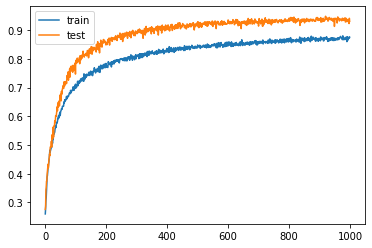

In [ ]:
plt.plot(history.history['acc'], label='train')
plt.plot(history.history['val_acc'], label='test')
plt.legend();